# COMPAS Case Study
This notebook answers the case study about **criminal injustice case study** from the fair ml book chapter 2. We begin by loading the data

In [47]:
import pandas as pd
import seaborn as sns 
import numpy as np

compas_raw = pd.read_csv("../../data/raw/compas-scores-two-years.csv")

print(f"The shape of the raw data is {compas_raw.shape}")

The shape of the raw data is (7214, 53)


We need to filter out rows where **days_b_screening_arrest** is over 30 or under -30 to achieve a data set with 6172 rows 

In [2]:
compas = compas_raw.loc[(compas_raw['days_b_screening_arrest'] <= 30) & (compas_raw['days_b_screening_arrest'] >= -30)]
assert(compas.shape[0] == 6172)

# Calibration and Sufficiency 
- Plot the fraction of defendants recidivating within two years as a function of risk score

In [72]:
# Subsetting people who recidivated that are either African-American or Caucasian
compas_subset = compas.loc[((compas['race']=='African-American') | (compas['race'] == 'Caucasian'))]
compas_subset.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
10,14,benjamin franc,benjamin,franc,2013-11-26,Male,1988-06-01,27,25 - 45,Caucasian,...,4,Low,2013-11-26,2013-11-25,2013-11-26,0,0,857,0,0


We need to plot the fraction of defendants recidivating within two years as a function of their risk score. Also we need to group this by race. 

In [104]:
compas_grouped = compas_subset.groupby(by=['race', 'decile_score']).agg(total_number_of_defendants=('id', 'count'),
                                                                          number_of_recid=('two_year_recid', lambda x: np.count_nonzero(x)),
                                                                          number_of_non_recid=('two_year_recid', lambda x: len(x)-np.count_nonzero(x)),
                                                                          fraction_of_recid=('two_year_recid', lambda x: np.count_nonzero(x)/len(x))).reset_index()
compas_grouped

,race,decile_score,total_number_of_defendants,number_of_recid,number_of_non_recid,fraction_of_recid
0,African-American,1,365,85,280,0.232877
1,African-American,2,346,105,241,0.303468
2,African-American,3,298,125,173,0.419463
3,African-American,4,337,158,179,0.468843
4,African-American,5,323,158,165,0.489164
5,African-American,6,318,187,131,0.588050
6,African-American,7,343,209,134,0.609329
7,African-American,8,301,215,86,0.714286
8,African-American,9,317,229,88,0.722397
9,African-American,10,227,190,37,0.837004


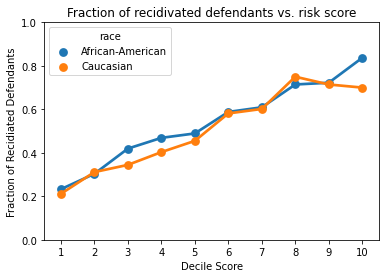

In [102]:
p1 = sns.pointplot(x = 'decile_score', y = 'fraction_of_recid', hue = 'race', data = compas_grouped)

p1 = p1.set(title='Fraction of recidivated defendants vs. risk score', 
            xlabel='Decile Score', 
            ylabel='Fraction of Recidiated Defendants',
            ylim=(0,1)
    )

## Q1: Does the risk score satisfy sufficiency across racial groups in this dataset?
From **fact 1** on page 16 of chapter 2 we know that calibration implies sufficiency. Calibration by group for a score *R* is satisfied if for a group $a$ we have that 
$$P\{Y = 1 | R= r, A = a\} = r$$
We see that the scores are somewhat calibrated, but the lines are en general not "steep" enough. As an example we see that 20% in both groups with a decile score of one have recidivated, this should only have been 10%. Similarly there are too few that have recidivated with a scre of 7 i.e. ~60%. What is more unsetteling from a fairness point of view is the gaps between the two lines around a decile score of 3 or 4 and again around 10. From this graph we see that "only" 70% Caucasians with a risk score of 10 recidivated opposing 84% of African Americans with a risk score of 10. Indicating that we have individuals in both groups, which have been classified with a too high risk score. Oppositly we see too many Arican Americans with a risk score of 3-4 compared to the fraction having recidivated. From these observations we would conclude that the score does not satisfy sufficency - as it is not calibrated for either group. 

# Error Rates and Seperation
We will now plot the distribution of scores recieved by the positive class (recidivists) and the distribution of scores recieved by the negative class (non-recidivists) for each of the racial groups. 